In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_style('darkgrid')

Данный небольшой датасет хранит в себе данные по просмотрам видео на **VK Video**, наша задача обработать и достать полезную информацию из данных. 

Описание столбцов:

1. `user_id` - идентификатор пользователя;

2. `video_owner_id` - идентификатор сообщества

3. `total_view_time` - время просмотра в секундах

4. `vk_platform` - платформа, с которой был произведен просмотр

-- vk_video_ios - приложение VK Видео на iOS;

-- vk_video_android - приложение VK Видео на android;

5. `nav_screen` - экран смотрения(Например: лента, страница сообщества, раздел рекомендаций);

-- video_for_you - блок рекомендаций а разделе Главная

-- video_search - поиск видео

-- video_group_all - раздел «Все видео» в сообществе

-- video_my_added - добавленные видео

-- video_my_history - раздел истории просмотра

-- video_group_main - главная страница сообщества

-- video_playlist - плейлист сообщества

-- video_my_bookmarks - раздел «Смотреть позже»

-- catalog_other - здесь все, что по каким-то причинам не залакировано

 6. `video_id` - идентификатор видео


Основными задачами станут:
1. Есть ли какие-то выбросы? Если да, то необходимо избавиться от них
2. Подсчитать какая платформа имела больше всего осознанных просмотров
(Осознанный просмотр - просмотр от 30 секунд) после очистки выбросов
3. Топ 10 сообществ по `total_view_time` после очистки выбросов

In [2]:
df_video = pd.read_csv('video_sessions_transformed.csv')

In [3]:
df_video.isnull().sum()

user_id            0
video_owner_id     0
total_view_time    0
vk_platform        0
nav_screen         0
video_id           0
dtype: int64

Пропущенных значений нет.

In [4]:
df_video['total_view_time'].describe()

count    4.503000e+03
mean     1.046599e+05
std      4.959592e+06
min     -3.000000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      2.405022e+08
Name: total_view_time, dtype: float64

Сразу наблюдаем очень большой максимум, что даёт нам понять о наличие аномалий, также заметен отрицательные значения, что явно не может отражать информацию о времени просмотра. 

Нужно построить box-plot для болей ясности

<Axes: ylabel='total_view_time'>

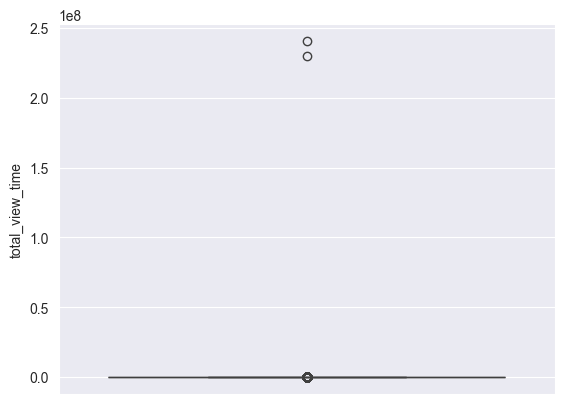

In [5]:
sns.boxplot(df_video['total_view_time'])

Нужно сделать диапазон значений меньше, чтобы понять, где примерно находятся реальные данные

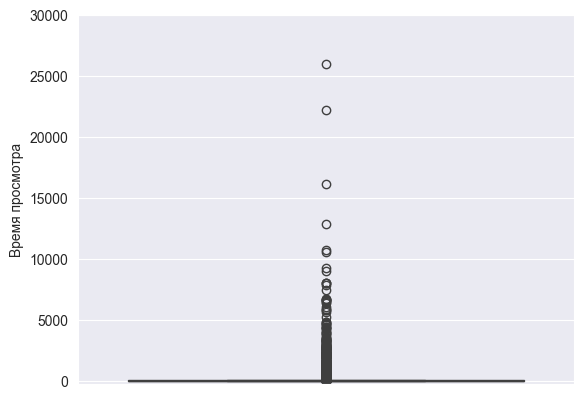

In [6]:
sns.boxplot(df_video['total_view_time'])
plt.ylabel('Время просмотра')
plt.ylim(-300,30000)
plt.show()

Медиана находится в 0 что говорит о том, что множество значений находится около 0, очень часто видео могут просто пролистнуть, поэтому это нормально. Также можно заметить, что есть значения около 30 000 секунд, что равно чуть больше 8 часов, да много, но в это можно поверить, в VK video нет ограничения на видео и тем-более на его просмотр, но если проводить сравнительный анализ, большие показатели будут сильно влиять на среднее время просмотра по платформе, поэтому анализ будет необъективен. Принимаю решение удалить значения выходящие за 99 процентиль, что позволит удалить слишком большие и оставить большую часть данных.

Отдельно сохраним датафрейм с информацией даже аномальной, но в теории возможной, так как для анализа частоты время не будет влиять.

Удалим слишком большие числа, также, чтобы исследовать только "осознанные" просмотры, будем учитывать случаи, когда просмотр видео длился более 30 секунд, так ещё вдобавок удалим отрицательные значения.

In [7]:
percentile_95 = df_video['total_view_time'].quantile(0.99)
df_video_proc = df_video[(df_video['total_view_time'] < percentile_95 ) & (df_video['total_view_time'] >= 30)]

df_video_with_anomaly = df_video[(df_video['total_view_time'] < 40000) & (df_video['total_view_time'] >= 30)]



In [8]:
df_video_proc['total_view_time'].describe()

count     353.000000
mean     1017.470255
std       962.924180
min        30.000000
25%       144.000000
50%       727.000000
75%      1573.000000
max      3538.000000
Name: total_view_time, dtype: float64

Получили информации о 353 осознанных просмотрах, теперь наши данные не выходят за диапазон времени просмотра в 1 один час, что позволит нам провести честный анализ.

<Axes: ylabel='total_view_time'>

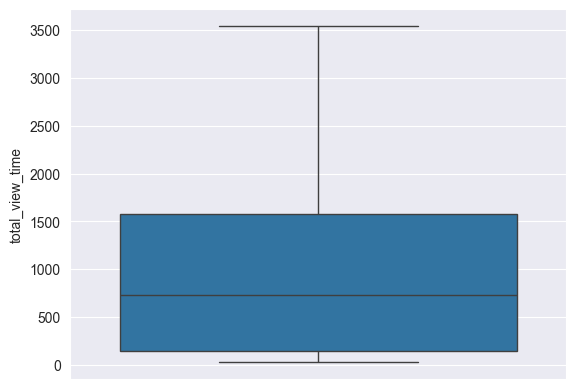

In [9]:
sns.boxplot(df_video_proc['total_view_time'])

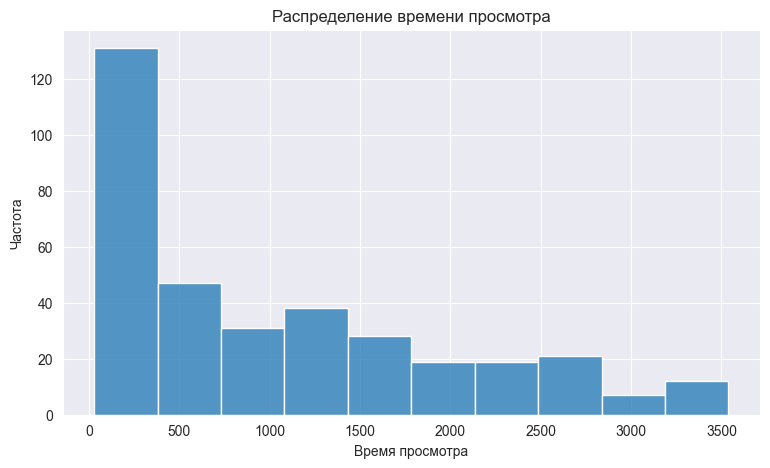

In [10]:
plt.figure(figsize=(9, 5))
sns.histplot(df_video_proc['total_view_time'])
plt.title("Распределение времени просмотра")
plt.ylabel('Частота')
plt.xlabel('Время просмотра')
plt.show()

### Посмотрим на Топ 10 сообществ по количеству просмотром, по датафрейму с большими, но реальными значениями

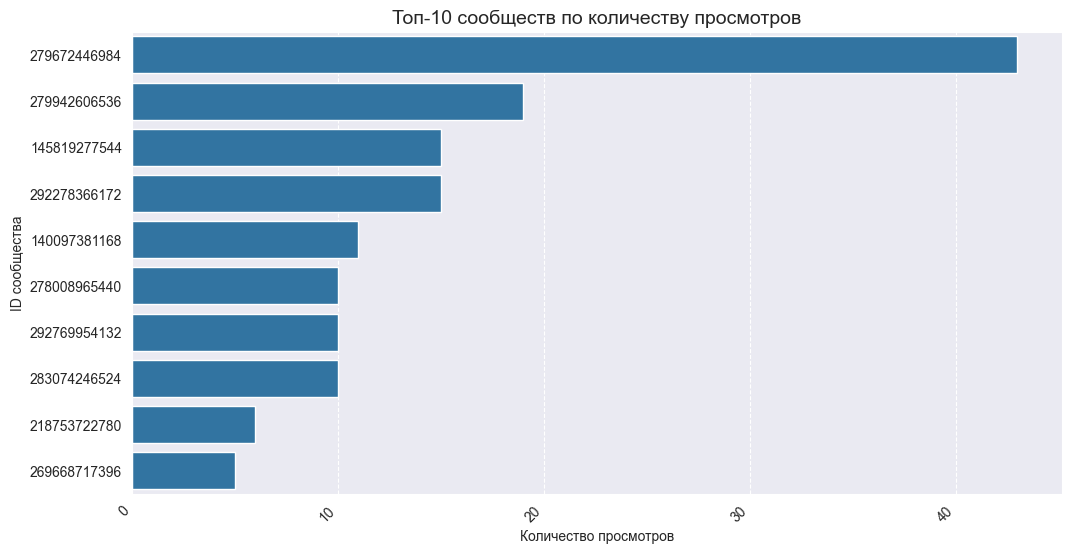

In [25]:
# Получаем топ-10 владельцев видео
top_owners = (df_video_with_anomaly
              .groupby('video_owner_id', as_index=False)
              .size()
              .sort_values('size', ascending=False)
              .rename(columns={'size': 'video_count'})
              .head(10))

# Создаем график
plt.figure(figsize=(12, 6))
sns.barplot(data=top_owners, 
            x='video_count', 
            y='video_owner_id',
            orient='h', order=top_owners['video_owner_id'])

plt.title('Топ-10 сообществ по количеству просмотров', fontsize=14)
plt.xlabel('Количество просмотров')
plt.ylabel('ID сообщества')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.xticks(rotation=45, ha='right')
plt.show()


Теперь по значениям без аномалий

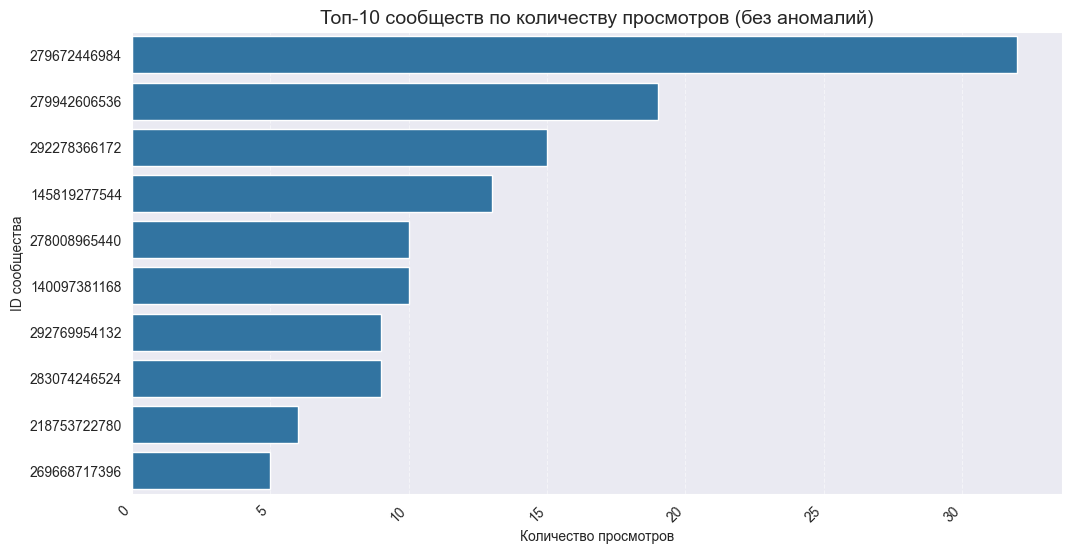

In [12]:
# Получаем топ-10 владельцев видео
top_owners = (df_video_proc
              .groupby('video_owner_id', as_index=False)
              .size()
              .sort_values('size', ascending=False)
              .rename(columns={'size': 'video_count'})
              .head(10))

# Создаем график
plt.figure(figsize=(12, 6))
sns.barplot(data=top_owners, 
            x='video_count', 
            y='video_owner_id',
            orient='h',
            order=top_owners['video_owner_id'])

plt.title('Топ-10 сообществ по количеству просмотров (без аномалий)', fontsize=14)
plt.xlabel('Количество просмотров')
plt.ylabel('ID сообщества')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Можно заметить, что у сообщества которое на первом месте, значительно прибавилось количество просмотров с большой длительностью просмотра. Это может значить разное либо у этого сообщества ролики имеют большую длительность, либо ВОЗМОЖНО здесь идёт накрутка активности сообщества, но здесь нельзя что-то точно утверждать без дополнительной информации. 


### **Проверим Топ 10 сообществ по среднему времени просмотра видео**

*Насколько хорошо сообщество завлекает пользователей*

Небольшое условие, чтобы участвовать в топе, сообществу нужно иметь, хотя-бы 5 просмотров, так как у сообщества с малым числом видео могут иметь случайно высокое среднее время просмотра из-за малой выборки, это ненадежно.



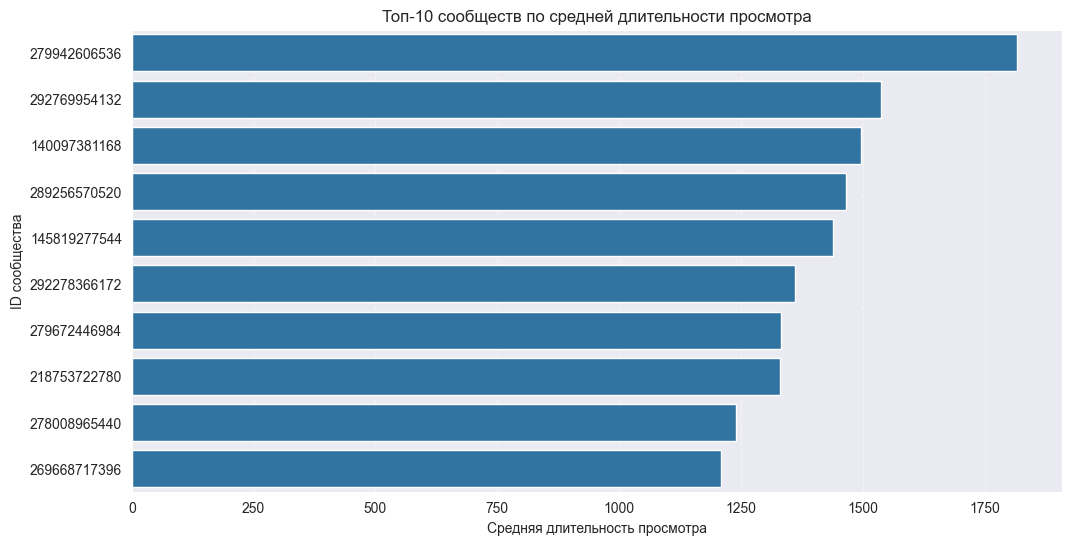

In [13]:
top_mean_watchers = (df_video_proc
              .groupby('video_owner_id', as_index=False)
              .agg(mean_view_time=('total_view_time', 'mean'), 
                 video_count=('total_view_time', 'count'))
                  .query('video_count >= 5')
              .sort_values('mean_view_time', ascending=False)
              .head(10))


plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_mean_watchers,
    x='mean_view_time', 
    y='video_owner_id',
    orient='h',
    order = top_mean_watchers['video_owner_id']
)

plt.title('Топ-10 сообществ по средней длительности просмотра')
plt.xlabel('Средняя длительность просмотра') 
plt.ylabel('ID сообщества')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Можно заметить, что у сообщества у которого было самое большое количество просмотров, занимает по среднему всего 7 место. Хотя нам это мало, так как чем большее число наблюдений, тем меньше становится разброс данных. 

По ЗБЧ чем больше данных, тем стабильнее и надежнее среднее значение



### Посмотрим, какая платформа (андроид/ios) лидирует по количеству просмотров

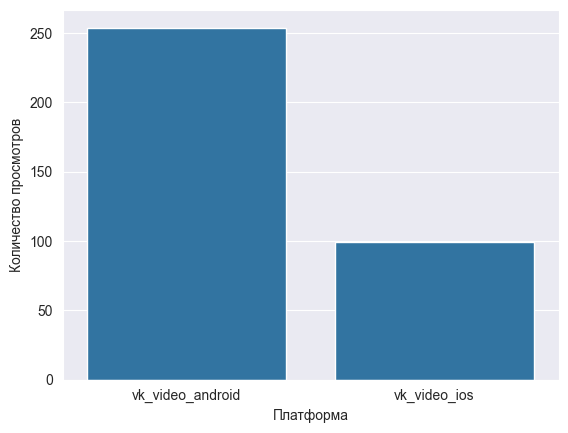

In [14]:
best_platform = df_video_proc.groupby(['vk_platform'], as_index=False)['total_view_time'].size().rename(columns={'size': 'total_view_time'})
sns.barplot(best_platform,
            x='vk_platform',
            y='total_view_time')
plt.ylabel('Количество просмотров')
plt.xlabel('Платформа')
plt.show()

**Пользователей смотрящих видео на Android больше чем смотрящих на ios**

Что действительно похоже на правду, так как пользователей Android в России, значительно больше пользователей Iphone. Но этого мало, чтобы понять есть ли действительно различия между данными платформами, для этого можно провести не большой статистический тест, в котором мы узнаем есть ли статистически значимые различие между средним временем просмотром на android и на ios

$H_0 \sim \mu_1= \mu_2$ - среднее количество времени, потраченное на просмотр видео на android равна времени на ios

$H_1 \sim \mu_1 \neq \mu_2$ - среднее количество времени, потраченное на просмотр видео на android не равна времени на ios

$\alpha = 0.05$ - типичный уровень значимости для такого теста

*Для более честного теста, видео будут отобраны только из поиска VK Video*

In [15]:
android = df_video_proc[(df_video_proc['vk_platform'] == 'vk_video_android') & (df_video_proc['nav_screen'] == 'video_search')]
ios_sample = df_video_proc[(df_video_proc['vk_platform'] == 'vk_video_ios') & (df_video_proc['nav_screen'] == 'video_search')]
print(f'Размер выборки который имеется в распоряжение - {ios_sample.shape[0]} элементов')

Размер выборки который имеется в распоряжение - 39 элементов


In [16]:
# Следственно нам нужно отобрать такой-же размер выборки и для android пользователей
android_sample = android.sample(n=ios_sample.shape[0], random_state=42) # Отберём 39 случайных андроид пользователей

android_mean = android_sample['total_view_time'].mean()
android_std = android_sample['total_view_time'].std()

ios_mean = ios_sample['total_view_time'].mean()
ios_std = ios_sample['total_view_time'].std()

print(f'Описательная статистика времени, потраченного на просмотр видео пользователями Android:\n'
    f'Среднее арифметическое: {android_mean/60:.2f} минут\n'
      f'Стандартное отклонение: {android_std/60:.2f} минут\n\n'
      f'Описательная статистика времени, потраченного на просмотр видео пользователями iOS:\n'
      f'Среднее арифметическое: {ios_mean/60:.2f} минут\n'
      f'Стандартное отклонение: {ios_std/60:.2f} минут'
      )



Описательная статистика времени, потраченного на просмотр видео пользователями Android:
Среднее арифметическое: 13.41 минут
Стандартное отклонение: 12.98 минут

Описательная статистика времени, потраченного на просмотр видео пользователями iOS:
Среднее арифметическое: 26.51 минут
Стандартное отклонение: 17.74 минут


Перед выбором теста проверим данные на нормальность. 

Для этого воспользуемся тестом на нормальность **Шапиро-Уилка**

$H_0$ - Распределение нормально

$H_1$ - Распределение ненормально

$\alpha = 0.05$ - типичный уровень значимости для такого теста

In [17]:
# Проверка нормальности (Shapiro-Wilk)
_, p_ios = stats.shapiro(ios_sample['total_view_time'])
_, p_android = stats.shapiro(android_sample['total_view_time'])

print(f"p-value (iOS): {p_ios:.3f}, p-value (Android): {p_android:.5f}")

p-value (iOS): 0.080, p-value (Android): 0.00015


p-value (Android) < 0.05 - Есть основания отвергнуть $H_0$, при уровне значимости 0.05. Распределение ненормально
 
Из-за распределения Android, мы не можем использовать статистические тесты для Нормального распределения. Так как распределение ненормально

Воспользуемся методом Манна-Уитни для ненормального распределения, чтобы оценить разность между выборками.

In [18]:
_, p_value = stats.mannwhitneyu(ios_sample['total_view_time'], 
                   android_sample['total_view_time'])
print(f"p-value {p_value}")

p-value 0.001384214542884491


p-value < 0.05 - Есть основания отвергнуть $H_0$, при уровне значимости 0.05.

Матожидание выборок различны, дальше нужно проверить, какая из выборок имеет большее среднее, чтобы определить, какая из платформ дольше смотрит ролики на VK Video

$H_0 \sim \mu_1 = \mu_2$ - среднее количество времени, потраченное на просмотр видео на ios равна времени на android

$H_1 \sim \mu_1 > \mu_2$ - среднее количество времени, потраченное на просмотр видео на ios больше чем времени на android

$\alpha = 0.05$ - типичный уровень значимости для такого теста

In [19]:
_, p_value = stats.mannwhitneyu(ios_sample['total_view_time'], 
                   android_sample['total_view_time'],
                                 alternative='greater')
print(p_value)

0.0006921072714422455


p-value < 0.05 - Есть основания отвергнуть $H_0$, при уровне значимости 0.05.

Пользователи на iOS смотрят видео дольше, чем пользователи android. С чем это связано я не знаю, возможно пользователи iOS более осознанно подходят к выбору ролика, поэтому и смотрят дольше. Также стоит отметить, что всё-таки стоит провести доп тесты, но только с более большой выборкой, так как будет больше вероятность, что распределения будут нормальны и появится возможность использовать другие тесты, также размер выборки позволит уменьшить доверительный интервал, что позволит уменьшить ошибку 2 рода.

### Определим где люди больше всего смотрят ролики (например: лента, страница сообщества, раздел рекомендаций);

In [20]:
top_screen = (df_video_proc
              .groupby('nav_screen', as_index=False)
              .size()
              .sort_values('size', ascending=False)
              .rename(columns={'size': 'video_count'})
              .head(10))

top_screen

,nav_screen,video_count
8,video_search,148
1,video_for_you,104
6,video_my_history,69
2,video_group_all,24
4,video_my_added,4
0,catalog_other,1
3,video_group_main,1
5,video_my_bookmarks,1
7,video_playlist,1


Больше всего осознанных просмотров приходится на поиск, когда человек целенаправлено ищет видео.

Также нужно посмотреть, на отношение осознанный просмотр на все просмотры, это нам сможет показать, какой элемент VK video лучше всего завлекает пользователя на просмотр видео, более чем 30 секунд.

In [21]:
top_screen_all = (df_video
              .groupby('nav_screen', as_index=False)
              .size()
              .sort_values('size', ascending=False)
              .rename(columns={'size': 'video_count'})
              .head(10))

top_screens = top_screen.merge(top_screen_all, on='nav_screen', how='left').rename(columns={'video_count_x': 'Осознанные просмотры', 'video_count_y': 'Все просмотры'})
top_screens['Отношение Осознанные/Все'] = top_screens['Осознанные просмотры'] / top_screens['Все просмотры']
top_screens

,nav_screen,Осознанные просмотры,Все просмотры,Отношение Осознанные/Все
0,video_search,148,2068,0.071567
1,video_for_you,104,2213,0.046995
2,video_my_history,69,95,0.726316
3,video_group_all,24,93,0.258065
4,video_my_added,4,14,0.285714
5,catalog_other,1,7,0.142857
6,video_group_main,1,2,0.500000
7,video_my_bookmarks,1,6,0.166667
8,video_playlist,1,4,0.250000


In [22]:
print(f'Рекомендации завлекают {top_screens['Отношение Осознанные/Все'].iloc[1]*100:.1f} % людей, которым была показана рекомендация\nПоиск способен завлечь всего {top_screens['Отношение Осознанные/Все'].iloc[0]*100:.1f} % людей, которые искали видео\nРаздел "Все видео" в сообществе завлекает {top_screens['Отношение Осознанные/Все'].iloc[3]*100:.1f} % людей')

Рекомендации завлекают 4.7 % людей, которым была показана рекомендация
Поиск способен завлечь всего 7.2 % людей, которые искали видео
Раздел "Все видео" в сообществе завлекает 25.8 % людей
